# Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
from lstm import LSTM
from ddpm import UNET, inference
from grayscott import GrayScott
from training import train_lstm, train_ddpm
from analyzer import Analyzer
from constants import *

# Device

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## LSTM Dataset

In [4]:
def create_sine_dataset(samples=100, seq_len=50):
    data = []
    for _ in range(samples):
        # Random frequency and phase to make it robust
        freq = np.random.uniform(0.5, 2.0)
        phase = np.random.uniform(0, 2*np.pi)
        t = np.linspace(0, 10, seq_len)
        
        # Signal = Sine + slight noise
        signal = np.sin(freq * t + phase) + 0.05 * np.random.randn(seq_len)
        data.append(signal)
    
    # Shape: [Batch, Seq_Len, Input_Size=1]
    return torch.FloatTensor(np.array(data)).unsqueeze(2)

# def create_shapes_dataset(samples=100, size=32):
#     data = []
#     for _ in range(samples):
#         img = np.zeros((size, size))
        
#         # Random Square
#         x = np.random.randint(5, size-10)
#         y = np.random.randint(5, size-10)
#         w = np.random.randint(5, 10)
#         img[x:x+w, y:y+w] = 1.0
        
#         data.append(img)
        
#     # Shape: [Batch, Channels=1, Height, Width]
#     return torch.FloatTensor(np.array(data)).unsqueeze(1)

In [5]:
samples = create_sine_dataset(100,50)
samples.size()

torch.Size([100, 50, 1])

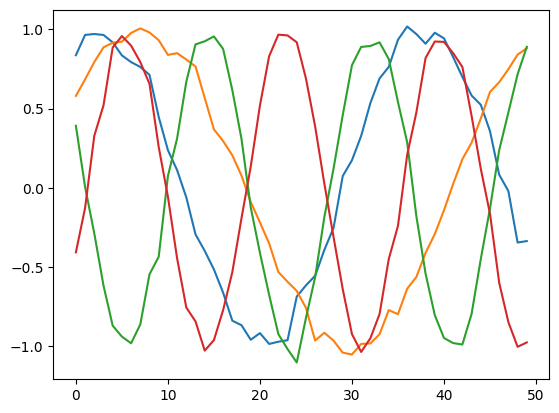

In [6]:
for _ in range(4):
    rand_index = random.randint(0, 100)
    plt.plot(samples[rand_index,:,0])

# LSTM Training

In [7]:
n_samples = 1000
seq_len = 50
n_epochs = 200

In [8]:
lstm_data = create_sine_dataset(samples=n_samples, seq_len=seq_len)
lstm_data = lstm_data.to(device)

lstm_model = LSTM(input_size=1, hidden_size=16).to(device)

--- Training LSTM on cpu ---
Epoch 0: Loss 0.39474
Epoch 10: Loss 0.13805
Epoch 20: Loss 0.04751
Epoch 30: Loss 0.03322
Epoch 40: Loss 0.02232
Epoch 50: Loss 0.01802
Epoch 60: Loss 0.01567
Epoch 70: Loss 0.01412
Epoch 80: Loss 0.01310
Epoch 90: Loss 0.01233
Epoch 100: Loss 0.01176
Epoch 110: Loss 0.01129
Epoch 120: Loss 0.01091
Epoch 130: Loss 0.01058
Epoch 140: Loss 0.01030
Epoch 150: Loss 0.01005
Epoch 160: Loss 0.00983
Epoch 170: Loss 0.00964
Epoch 180: Loss 0.00946
Epoch 190: Loss 0.00929


Text(0.5, 0, 'epoch')

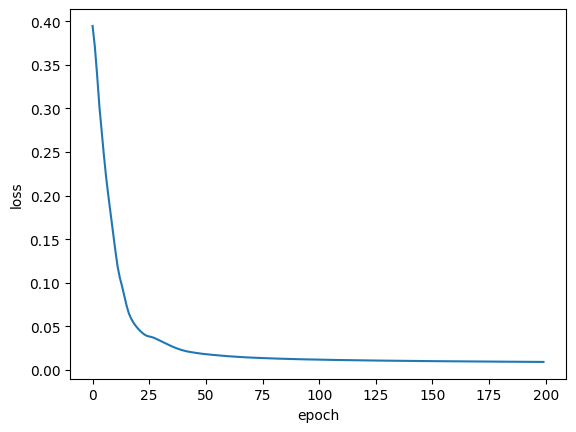

In [9]:
loss_lstm = train_lstm(lstm_model, lstm_data, num_epochs=n_epochs, lr=1e-2, device=device)

plt.plot(loss_lstm)
plt.ylabel("loss")
plt.xlabel("epoch")

Seed shape: torch.Size([50, 1])
Seed values: tensor([[-0.3477],
        [-0.6207],
        [-0.8394],
        [-0.8991],
        [-1.0264]])
Generated shape: torch.Size([100, 1])
Generated values: tensor([[-0.3996],
        [-0.5788],
        [-0.6494],
        [-0.5960],
        [-0.4354]])


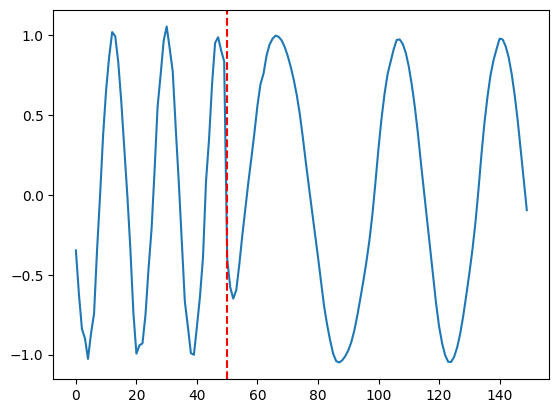

In [10]:
rand_index = random.randint(0, n_samples)
seed_sample = lstm_data[rand_index]

future_steps = 2*seq_len
generated, history_generated = lstm_model.generate_sequence(seed_sample, future_steps=future_steps)

print(f"Seed shape: {seed_sample.shape}")
print(f"Seed values: {seed_sample[:5]}")
print(f"Generated shape: {generated.shape}")
print(f"Generated values: {generated[:5]}")

plt.plot(torch.cat((seed_sample.to("cpu"), generated.to("cpu"))))
plt.axvline(x=seq_len, color='red', linestyle='--')

# LSTM Visualization

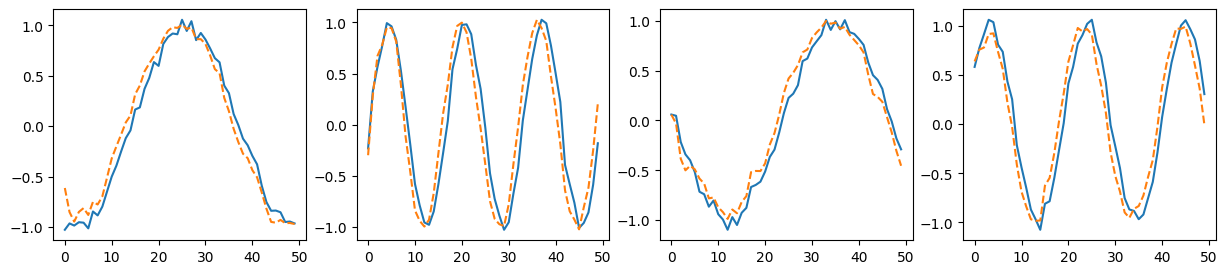

In [12]:
lstm_out, history = lstm_model(lstm_data)
fig, ax = plt.subplots(1,4, figsize=(15,3))
for i in range(4):
    rand_index = random.randint(0,n_samples)
    ax[i].plot(lstm_data[rand_index,:,0].to("cpu").detach().numpy(), label="true data")
    ax[i].plot(lstm_out[rand_index,:,0].to("cpu").detach().numpy(), linestyle="--", label="lstm output")

plt.show()

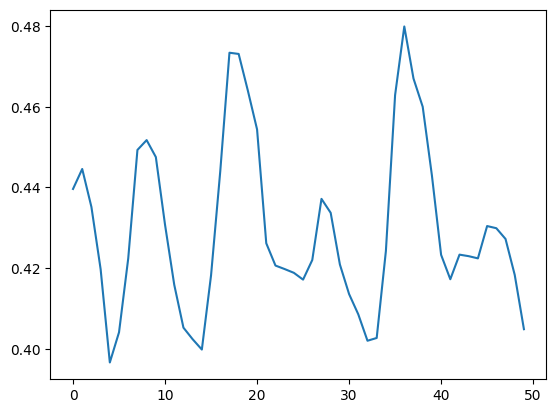

In [24]:
forget = [[t[3, d].item() for t in history["forget"]] for d in range(16)]
def mean_forget(forget):
    l = []
    s = 0
    for j in range(seq_len):
        for i in range(16):
            s += forget[i][j]
        l.append(s/16)
        s=0
    return l
forget_mean = mean_forget(forget)
plt.plot(forget_mean)

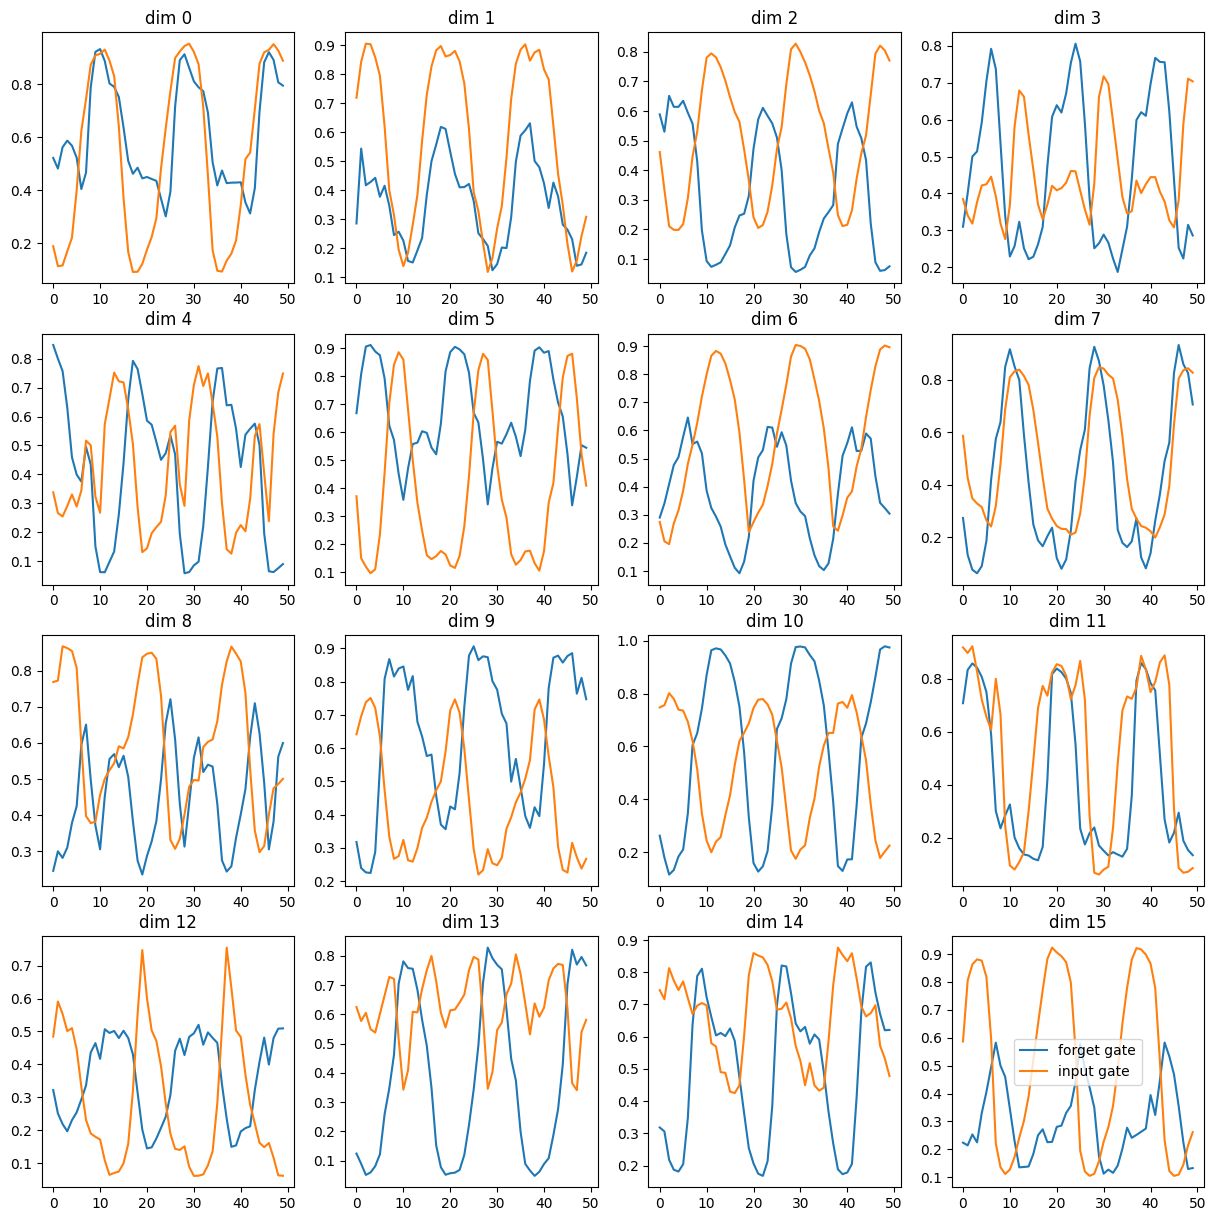

In [23]:
fig, ax = plt.subplots(4,4, figsize=(15,15))

rand_sample = random.randint(0,100)
forget_gate = [[t[rand_sample, d].item() for t in history["forget"]] for d in range(16)]
input_gate = [[t[rand_sample, d].item() for t in history["input"]] for d in range(16)]

for i in range(4):
    for j in range(4):
        ax[i,j].plot(forget_gate[4*i+j], label="forget gate")
        ax[i,j].plot(input_gate[4*i+j], label="input gate")
        ax[i,j].set_title(f"dim {4*i+j}")

plt.legend()
plt.show()

In [24]:
def extract_lstm_gates(model, input_seq):
    """
    Manually steps through the LSTM to save Input(i) and Forget(f) gates.
    """
    model.eval()
    
    # Initialize states
    h = torch.zeros(1, 16).to(input_seq.device) # Assuming hidden_size=16
    c = torch.zeros(1, 16).to(input_seq.device)
    
    i_gates = []
    f_gates = []
    
    with torch.no_grad():
        for t in range(input_seq.shape[1]):
            x_t = input_seq[:, t, :]
            
            # Use the cell directly!
            # The InspectableLSTMCell returns: h, c, dynamics_dict
            h, c, dynamics = model.cell(x_t, h, c)
            
            # We average the gates across the 16 hidden units 
            # to get a single "global" activator/inhibitor signal for the plot
            i_val = dynamics['input'].mean().item()
            f_val = dynamics['forget'].mean().item()
            
            i_gates.append(i_val)
            f_gates.append(f_val)
            
    return np.array(i_gates), np.array(f_gates)

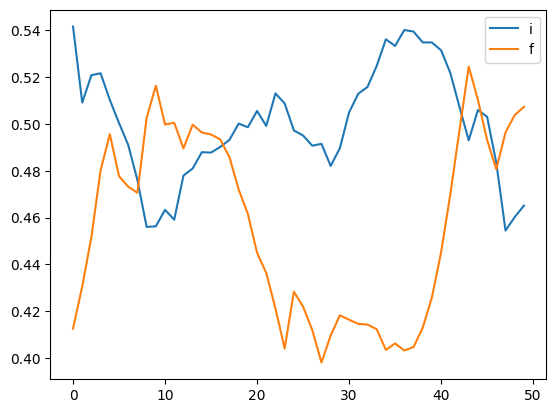

In [37]:
rand_index = random.randint(0, n_samples)
seed_sample = lstm_data[rand_index].view(1,seq_len,1)
test_input = torch.sin(torch.linspace(0, 20, 100)).view(1, 100, 1)
lstm_i, lstm_f = extract_lstm_gates(lstm_model, seed_sample)
plt.plot(lstm_i, label="i")
plt.plot(lstm_f, label="f")
plt.legend()
plt.show()

# DDPM Training

In [ ]:
n_epoch = 20
batch_size = 128
n_T = 400

In [ ]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True,transform=transforms.ToTensor())
ddpm_model = UNET(Channels=[32, 64, 128, 256, 256, 192],          # Much smaller
                  Attentions=[False, True, False, False, True, False], # Keep attention sparse
                  Upscales=[False, False, False, True, True, True],
                  num_groups=8  # Reduce groups since channels are smaller
              ).to(device)

Epoch 1/1: 100%|██████████| 93/93 [10:46<00:00,  6.95s/it]


Epoch 1 | Loss 0.06729


Text(0.5, 0, 'epoch')

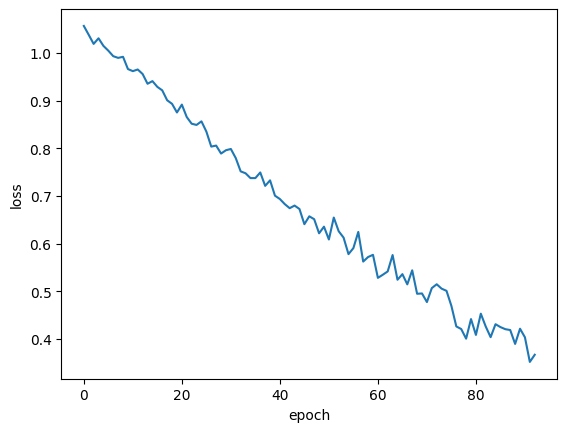

In [ ]:
losses = train_ddpm(ddpm_model, train_dataset, batch_size=batch_size, num_time_steps=n_T lr=2e-5, num_epochs=1, device=device)

plt.plot(losses)
plt.ylabel("loss")
plt.xlabel("epoch")

In [38]:
inference(ddpm_model=ddpm_model, checkpoint_path="checkpoints/ddpm_checkpoint", num_time_steps=n_T)

NameError: name 'ddpm_model' is not defined

# Comparison

In [ ]:
# 1. Get Gray Scott Data
# gs is your GrayScott instance
# gs_history should be a list of frames you saved during the loop
gs = GrayScott(F=F_DEFAULT, k=k_DEFAULT, D_u=Du_DEFAULT, D_v=Dv_DEFAULT, x0=x0, x1=x1, N=N)
_, V_final, V_history, _, _ = gs.forward(0, 5000, frame=False, data=False)
gs_final = V_final[1:-1, 1:-1]
gs_history = np.array(V_history) # Shape: [Time, H, W]

# 2. Get LSTM Data
# output is the predicted sequence [Batch, Seq, 1]
lstm = LSTM().to(device)
lstm_output, _ = lstm.forward(lstm_data)
lstm_final = lstm_output[0, :, 0].to("cpy").detach().numpy()
lstm_history = lstm_output[0, :, :].to("cpu").detach().numpy() # Treat sequence as history

# 3. Get DDPM Data
# final_img is [1, 28, 28]
# history is list of arrays [Time, 1, 28, 28]
ddpm_final_img, ddpm_history_list = ddpm_model.sample(1,)
ddpm_final = ddpm_final_img.squeeze().cpu().numpy()
ddpm_history = np.array([x.squeeze() for x in ddpm_history_list])

# 4. Run Comparison
analyzer = Analyzer()
analyzer.compare_models(gs_final, gs_history, 
                        lstm_final, lstm_history, 
                        ddpm_final, ddpm_history)

F=0.054, k=0.062: 100%|███████████████████████████████████████▉| 8190/8192 [00:13<00:00, 593.99it/s]
